### SI Figure to investigate and quantify optical crowding effects

In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [2]:
# Load postprocessed MERFISH and MACA results
# We should run SI fig 2 first to determine the count threshold cutoff, and then create
# the filtered .h5ad object to use here eventually.

# Define the path of the analyzed MERFISH data
dataPathPost = '/mnt/ibm_lg/spatial-seq/MERlin_Analysis/ProcessedResults'

# Define the experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921',
                  'MsKidney_CellBoundary_VZG116_121021']
prefixCountsFilter = 'FilteredCounts'
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCountsFilter = []
QCFilter = []

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

    # Get filtering criteria
    QCFilter.append(VizgenCountsFilter[i].uns['QC_filter'])
    


# Convert all gene names to lower case
for i in range(len(experimentName)):
    VizgenCountsFilter[i].var.index = VizgenCountsFilter[i].var.index.str.lower()
    
# Rename the 5 genes that are inconsistent with MACA (NOTE: MIR205HG doesn't seem to be in MACA at all)
rename_map = {'mir205hg':'4631405k08rik',
             'ackr1':'darc',
             'adgrl4':'eltd1',
             'cavin2':'sdpr',
             'jchain':'igj'}
for i in range(len(experimentName)):
    gene_list = list(VizgenCountsFilter[i].var.index)
    for j in range(len(gene_list)):
        if gene_list[j] in rename_map.keys():
            gene_list[j] = rename_map[gene_list[j]]
    VizgenCountsFilter[i].var.index = gene_list


# Combine into single tissue objects
liver_ind = [0]
kidney_ind = [1,2]
VizgenLiver_all = []
VizgenKidney_all = []

for i in liver_ind:
    VizgenLiver_all.append(VizgenCountsFilter[i])
    
for i in kidney_ind:
    VizgenKidney_all.append(VizgenCountsFilter[i])

VizgenLiver = VizgenLiver_all[0]
for i in range(len(liver_ind)-1):
    VizgenLiver = VizgenLiver.concatenate(VizgenLiver_all[i+1])
    
VizgenKidney = VizgenKidney_all[0]
for i in range(len(kidney_ind)-1):
    VizgenKidney = VizgenKidney.concatenate(VizgenKidney_all[i+1])
    
# Load raw MACA data (10x)
dataPathMACA = '/mnt/ibm_lg/angela/'
experimentMACA10x = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'
MACA_10x = anndata.read(os.path.join(dataPathMACA, experimentMACA10x))

# Use only the reference datasets that are 18 months or younger
# ind = np.logical_or(np.logical_or(MACA_10x.obs['age'] == '1m', MACA_10x.obs['age'] == '3m'),
#                    MACA_10x.obs['age'] == '18m')
ind = MACA_10x.obs['age'] == '3m' # Use only 3 month old mice

MACA_10x = MACA_10x[ind]

# Load raw MACA data (SmartSeq)
experimentMACASmartSeq = 'tabula-muris-senis-facs-official-raw-obj.h5ad'
MACA_SmartSeq = anndata.read(os.path.join(dataPathMACA, experimentMACASmartSeq))

# Select only the tissue-specific cells from the raw datasets
MACAliver_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Liver'].copy()
MACAliver_SmartSeq = MACA_SmartSeq[MACA_SmartSeq.obs['tissue'] == 'Liver'].copy()
MACAkidney_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Kidney'].copy()
MACAkidney_SmartSeq = MACA_SmartSeq[MACA_SmartSeq.obs['tissue'] == 'Kidney'].copy()


# Convert genes to lower case
MACAliver_10x.var.index = MACAliver_10x.var.index.str.lower()
MACAliver_SmartSeq.var.index = MACAliver_SmartSeq.var.index.str.lower()
MACAkidney_10x.var.index = MACAkidney_10x.var.index.str.lower()
MACAkidney_SmartSeq.var.index = MACAkidney_SmartSeq.var.index.str.lower()

# Select shared gene panel genes only
genes_Vizgen = VizgenCountsFilter[0].var.index
genes_10x = MACAliver_10x.var.index
genes_SmartSeq = MACAliver_SmartSeq.var.index
genes_shared = genes_Vizgen.intersection(genes_10x) # List of shared genes

VizgenLiver = VizgenLiver[:, genes_Vizgen.isin(genes_shared)].copy()
VizgenKidney = VizgenKidney[:, genes_Vizgen.isin(genes_shared)].copy()
MACAliver_10x = MACAliver_10x[:, genes_10x.isin(genes_shared)]
MACAliver_SmartSeq = MACAliver_SmartSeq[:, genes_SmartSeq.isin(genes_shared)]
MACAkidney_10x = MACAkidney_10x[:, genes_10x.isin(genes_shared)]
MACAkidney_SmartSeq = MACAkidney_SmartSeq[:, genes_SmartSeq.isin(genes_shared)]

# Remove MERFISH cells with fewer than 20 counts (since we removed 5 genes that weren't in MACA)
min_counts = 20
scanpy.pp.filter_cells(VizgenLiver, min_counts=min_counts)
scanpy.pp.filter_cells(VizgenKidney, min_counts=min_counts)
    
print('Processed data loaded.')

Processed data loaded.


### Panel A and B: distributions of median counts for liver and kidney from MACA

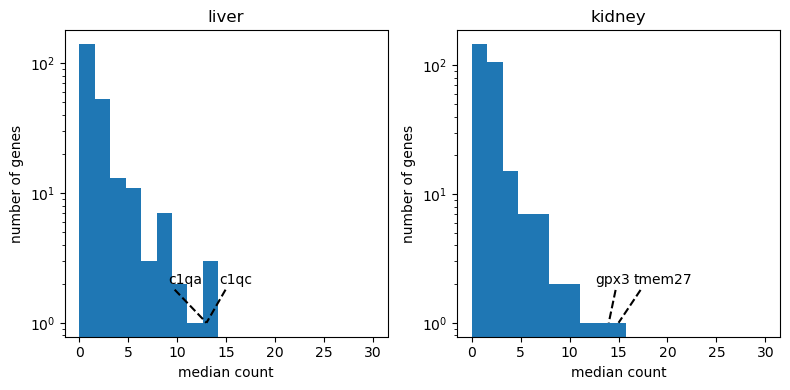

In [3]:
# Calculate median expression of each gene (excluding zeros)
MACAliver_temp = MACAliver_10x.to_df().copy().replace(0,np.nan)
MACAkidney_temp = MACAkidney_10x.to_df().copy().replace(0,np.nan)

MACAliver_median = MACAliver_temp.median(axis=0)
MACAkidney_median = MACAkidney_temp.median(axis=0)

# Get the names of the highest 2 expressing genes in each tissue
highest_genes_liver = MACAliver_median.nlargest(2).index
highest_exp_liver = MACAliver_median.nlargest(2)
highest_genes_kidney = MACAkidney_median.nlargest(2).index
highest_exp_kidney = MACAkidney_median.nlargest(2)

# Plot histogram of medians and total cell counts
bins = np.linspace(0,30,20)
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]
ax.hist(MACAliver_median, bins=bins)
ax.set_xlabel('median count')
ax.set_ylabel('number of genes')
ax.set_title('liver')
ax.set_yscale('log')

# Add gene annotations
ax.text(highest_exp_liver[0]*1.1, 2, highest_genes_liver[0])
ax.text(highest_exp_liver[1]*0.7, 2, highest_genes_liver[1])
ax.plot([highest_exp_liver[0]*1.15,highest_exp_liver[0]], [1.8,1], 'k--')
ax.plot([highest_exp_liver[1]*0.75,highest_exp_liver[1]], [1.8,1], 'k--')

ax = axes[1]
ax.hist(MACAkidney_median, bins=bins)
ax.set_xlabel('median count')
ax.set_ylabel('number of genes')
ax.set_title('kidney')
ax.set_yscale('log')

# Add gene annotations
ax.text(highest_exp_kidney[0]*1.1, 2, highest_genes_kidney[0])
ax.text(highest_exp_kidney[1]*0.9, 2, highest_genes_kidney[1])
ax.plot([highest_exp_kidney[0]*1.15,highest_exp_kidney[0]], [1.8,1], 'k--')
ax.plot([highest_exp_kidney[1]*1.05,highest_exp_kidney[1]], [1.8,1], 'k--')

fig.tight_layout()
plt.show()

### Panel C and D: distributions of a few abundant genes between Vizgen and MACA for liver and kidney

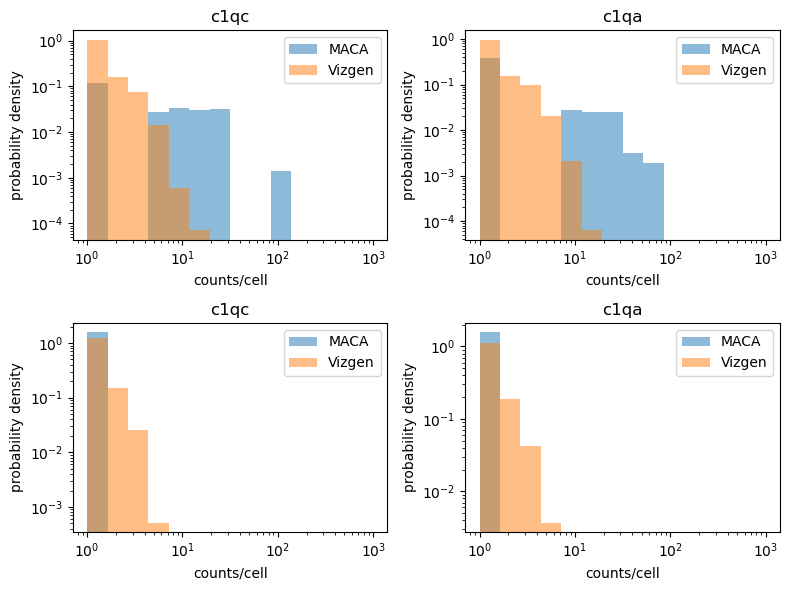

In [4]:
# Split the cells in each dataset into < and > 100 total counts/cell
count_threshold = 100
MACAliver_10x_bottomcells = MACAliver_10x[MACAliver_10x.to_df().sum(axis=1) < count_threshold,:]
MACAliver_10x_topcells = MACAliver_10x[MACAliver_10x.to_df().sum(axis=1) >= count_threshold,:]
VizgenLiver_bottomcells = VizgenLiver[VizgenLiver.to_df().sum(axis=1) < count_threshold,:]
VizgenLiver_topcells = VizgenLiver[VizgenLiver.to_df().sum(axis=1) >= count_threshold,:]


# Plot the Vizgen vs MACA histograms across cells for these genes
fig, ax = plt.subplots(2,2,figsize=(8,6))
bins = np.logspace(0,3,15)

# Most abundant genes in highest count cells
for i, gene in enumerate(highest_genes_liver):
    ax[0,i].hist(MACAliver_10x_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MACA')
    ax[0,i].hist(VizgenLiver_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='Vizgen')
    ax[0,i].set_title(gene)
    ax[0,i].set_xlabel('counts/cell')
    ax[0,i].set_ylabel('probability density')
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[0,i].legend()
    
# Most abundant genes in lowest count cells
for i, gene in enumerate(highest_genes_liver):
    ax[1,i].hist(MACAliver_10x_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MACA')
    ax[1,i].hist(VizgenLiver_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='Vizgen')
    ax[1,i].set_title(gene)
    ax[1,i].set_xlabel('counts/cell')
    ax[1,i].set_ylabel('probability density')
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].legend()
    
fig.tight_layout()
plt.show()

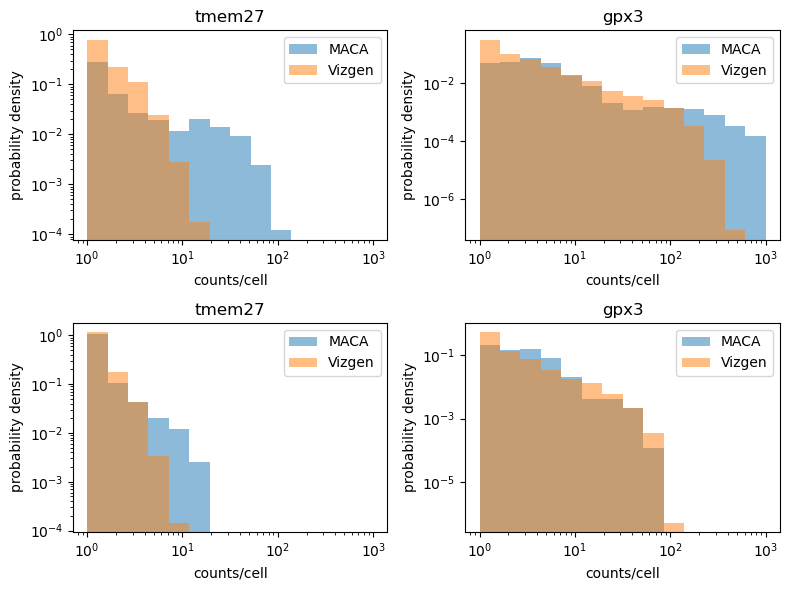

In [5]:
# Split the cells in each dataset into < and > 100 total counts/cell
count_threshold = 100
MACAkidney_10x_bottomcells = MACAkidney_10x[MACAkidney_10x.to_df().sum(axis=1) < count_threshold,:]
MACAkidney_10x_topcells = MACAkidney_10x[MACAkidney_10x.to_df().sum(axis=1) >= count_threshold,:]
VizgenKidney_bottomcells = VizgenKidney[VizgenKidney.to_df().sum(axis=1) < count_threshold,:]
VizgenKidney_topcells = VizgenKidney[VizgenKidney.to_df().sum(axis=1) >= count_threshold,:]


# Plot the Vizgen vs MACA histograms across cells for these genes
fig, ax = plt.subplots(2,2,figsize=(8,6))
bins = np.logspace(0,3,15)

# Most abundant genes in highest count cells
for i, gene in enumerate(highest_genes_kidney):
    ax[0,i].hist(MACAkidney_10x_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MACA')
    ax[0,i].hist(VizgenKidney_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='Vizgen')
    ax[0,i].set_title(gene)
    ax[0,i].set_xlabel('counts/cell')
    ax[0,i].set_ylabel('probability density')
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[0,i].legend()
    
# Most abundant genes in lowest count cells
for i, gene in enumerate(highest_genes_kidney):
    ax[1,i].hist(MACAkidney_10x_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MACA')
    ax[1,i].hist(VizgenKidney_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='Vizgen')
    ax[1,i].set_title(gene)
    ax[1,i].set_xlabel('counts/cell')
    ax[1,i].set_ylabel('probability density')
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].legend()
    
fig.tight_layout()
plt.show()

### Panel C, D: histogram of KS distances/gene for each tissue type between the two technologies
(skipping this for now)

In [6]:
# # Liver

# ks_liver_bottomcells = []
# ks_liver_topcells = []
# N_genes = VizgenLiver.shape[1]

# for i in tqdm(range(N_genes)):
#     Vizgen_bottom = np.squeeze(VizgenLiver_bottomcells[:,i].X.toarray())
#     MACA_bottom = np.squeeze(MACAliver_10x_bottomcells[:,i].X.toarray())
#     ks_liver_bottomcells.append(ks_2samp(Vizgen_bottom, MACA_bottom)[0])
    
#     Vizgen_top = np.squeeze(VizgenLiver_topcells[:,i].X.toarray())
#     MACA_top = np.squeeze(MACAliver_10x_topcells[:,i].X.toarray())
#     ks_liver_topcells.append(ks_2samp(Vizgen_top, MACA_top)[0])
    
# # Kidney
# ks_kidney_bottomcells = []
# ks_kidney_topcells = []

# for i in tqdm(range(N_genes)):
#     Vizgen_bottom = np.squeeze(VizgenKidney_bottomcells[:,i].X.toarray())
#     MACA_bottom = np.squeeze(MACAkidney_10x_bottomcells[:,i].X.toarray())
#     ks_kidney_bottomcells.append(ks_2samp(Vizgen_bottom, MACA_bottom)[0])
    
#     Vizgen_top = np.squeeze(VizgenKidney_topcells[:,i].X.toarray())
#     MACA_top = np.squeeze(MACAkidney_10x_topcells[:,i].X.toarray())
#     ks_kidney_topcells.append(ks_2samp(Vizgen_top, MACA_top)[0])
    
# print('K-S distances calculated.')

In [7]:
# # Plot histograms of K-S distances
# bins = np.linspace(0,1,20)
# fig, axes = plt.subplots(2,2, figsize=(12,8))

# ax = axes[0,0]
# ax.hist(ks_liver_bottomcells, bins=bins, alpha=0.5, label='counts/cell < 100')
# ax.hist(ks_liver_topcells, bins=bins, alpha=0.5, label='counts/cell > 100')
# ax.set_xlabel('Kolmogorov-Smirnov distance')
# ax.set_ylabel('number of genes')
# ax.legend()
# ax.set_title('liver')

# ax = axes[0,1]
# ax.hist(ks_kidney_bottomcells, bins=bins, alpha=0.5, label='counts/cell < 100')
# ax.hist(ks_kidney_topcells, bins=bins, alpha=0.5, label='counts/cell > 100')
# ax.set_xlabel('Kolmogorov-Smirnov distance')
# ax.set_ylabel('number of genes')
# ax.legend()
# ax.set_title('kidney')

# # Plot histograms of fold-change in K-S distances between subsets
# bins = np.linspace(-1,10,20)

# ax = axes[1,0]
# ax.hist(np.array(ks_liver_topcells) / np.array(ks_liver_bottomcells), bins=bins)
# ax.set_xlabel('fold-change K-S distance')
# ax.set_ylabel('number of genes')
# ax.set_title('liver')

# ax = axes[1,1]
# ax.hist(np.array(ks_kidney_topcells) / np.array(ks_kidney_bottomcells), bins=bins)
# ax.set_xlabel('fold-change K-S distance')
# ax.set_ylabel('number of genes')
# ax.set_title('liver')

# fig.tight_layout()
# plt.show()

### Plot combined figure

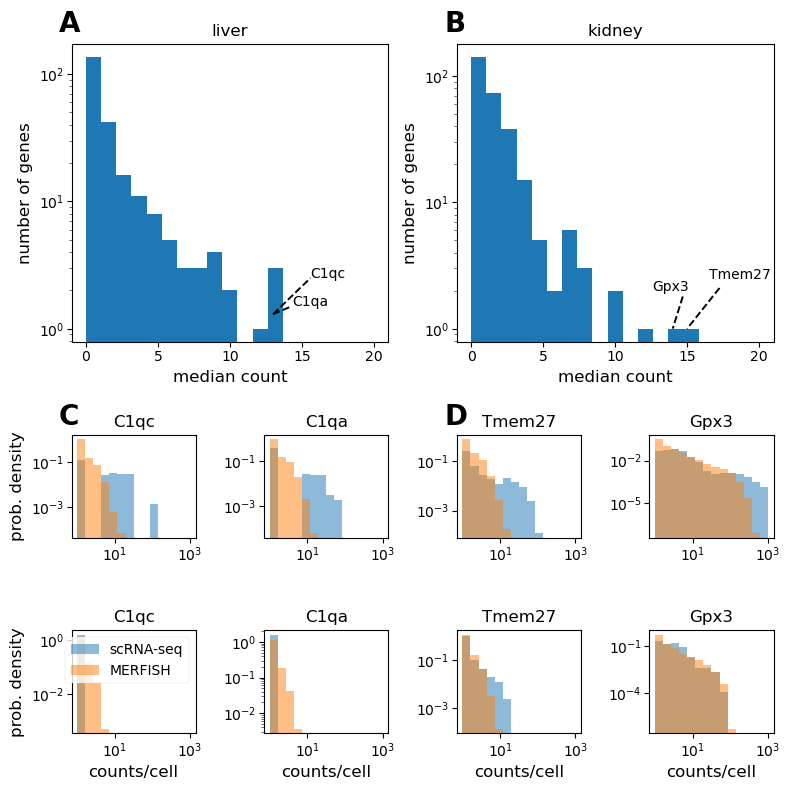

In [23]:
# Plot the whole figure

set_plotting_style()

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8,8)) #Create a grid
gs = axes[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A, B
for i in [0,1]:
    for j in [0,1,2,3]:
        axes[i,j].remove()

axbig1 = fig.add_subplot(gs[0:2, 0:2])
axbig2 = fig.add_subplot(gs[0:2, 2:4])

# Plot histogram of medians and total cell counts
bins = np.linspace(0,20,20)

# Panel A: liver
ax = axbig1
ax.hist(MACAliver_median, bins=bins)
ax.set_xlabel('median count')
ax.set_ylabel('number of genes')
ax.set_title('liver')
ax.set_yscale('log')

# Add gene annotations
ax.text(highest_exp_liver[0]*1.2, 2.5, highest_genes_liver[0].capitalize())
ax.text(highest_exp_liver[1]*1.1, 1.5, highest_genes_liver[1].capitalize())
ax.plot([highest_exp_liver[0],highest_exp_liver[0]*1.2], [1.3,2.5], 'k--')
ax.plot([highest_exp_liver[1],highest_exp_liver[1]*1.1], [1.3,1.5], 'k--')

# Panel B: kidney
ax = axbig2
ax.hist(MACAkidney_median, bins=bins)
ax.set_xlabel('median count')
ax.set_ylabel('number of genes')
ax.set_title('kidney')
ax.set_yscale('log')

# Add gene annotations
ax.text(highest_exp_kidney[0]*1.1, 2.5, highest_genes_kidney[0].capitalize())
ax.text(highest_exp_kidney[1]*0.9, 2, highest_genes_kidney[1].capitalize())
ax.plot([highest_exp_kidney[0]*1.15,highest_exp_kidney[0]], [2.1,1], 'k--')
ax.plot([highest_exp_kidney[1]*1.05,highest_exp_kidney[1]], [1.8,1], 'k--')

# Panel C: sample distributions for liver
bins = np.logspace(0,3,15)

# Most abundant genes in highest count cells
ax = axes[2:4,0:2]
for i, gene in enumerate(highest_genes_liver):
    ax[0,i].hist(MACAliver_10x_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='scRNA-seq')
    ax[0,i].hist(VizgenLiver_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MERFISH')
    ax[0,i].set_title(gene.capitalize())
    #ax[0,i].set_xlabel('counts/cell')
    #ax[0,i].set_ylabel('prob. density')
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    #ax[0,i].legend()
ax[0,0].set_ylabel('prob. density')

    
# Most abundant genes in lowest count cells
for i, gene in enumerate(highest_genes_liver):
    ax[1,i].hist(MACAliver_10x_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='scRNA-seq')
    ax[1,i].hist(VizgenLiver_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MERFISH')
    ax[1,i].set_title(gene.capitalize())
    ax[1,i].set_xlabel('counts/cell')
    #ax[1,i].set_ylabel('prob. density')
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    #ax[1,i].legend()
ax[1,0].set_ylabel('prob. density')
ax[1,0].legend()

    
# Panel D: sample distributions for kidney
bins = np.logspace(0,3,15)
ax = axes[2:4,2:4]

# Most abundant genes in highest count cells
for i, gene in enumerate(highest_genes_kidney):
    ax[0,i].hist(MACAkidney_10x_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='scRNA-seq')
    ax[0,i].hist(VizgenKidney_topcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MERFISH')
    ax[0,i].set_title(gene.capitalize())
    #ax[0,i].set_xlabel('counts/cell')
    #ax[0,i].set_ylabel('prob. density')
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    #ax[0,i].legend()
    
# Most abundant genes in lowest count cells
for i, gene in enumerate(highest_genes_kidney):
    ax[1,i].hist(MACAkidney_10x_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='scRNA-seq')
    ax[1,i].hist(VizgenKidney_bottomcells[:,gene].X.toarray(), 
                 alpha=0.5, density=True, bins=bins, label='MERFISH')
    ax[1,i].set_title(gene.capitalize())
    ax[1,i].set_xlabel('counts/cell')
    #ax[1,i].set_ylabel('prob. density')
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    #ax[1,i].legend()
    
# # Panel C: K-S distances for liver
# bins = np.linspace(0,1,20)

# ax = axbig1
# ax.hist(ks_liver_bottomcells, bins=bins, alpha=0.5, label='counts/cell < 100')
# ax.hist(ks_liver_topcells, bins=bins, alpha=0.5, label='counts/cell > 100')
# ax.set_xlabel('Kolmogorov-Smirnov distance')
# ax.set_ylabel('number of genes')
# ax.set_xlim((0,1))
# ax.set_ylim((0,160))
# ax.legend()
# ax.set_title('liver')

# # Panel C inset: fold-change K-S distance for liver
# bins = np.linspace(-1,20,20)
# inset1 = axbig1.inset_axes([0.35, 45, 0.6, 80], transform=axbig1.transData)
# inset1.hist(np.array(ks_liver_topcells) / np.array(ks_liver_bottomcells), bins=bins)
# inset1.set_xlabel('fold-change')

# # Panel D: K-S distances for kidney
# bins = np.linspace(0,1,20)
# ax = axbig2
# ax.hist(ks_kidney_bottomcells, bins=bins, alpha=0.5, label='counts/cell < 100')
# ax.hist(ks_kidney_topcells, bins=bins, alpha=0.5, label='counts/cell > 100')
# ax.set_xlabel('Kolmogorov-Smirnov distance')
# ax.set_ylabel('number of genes')
# ax.set_xlim((0,1))
# ax.set_ylim((0,160))
# ax.legend()
# ax.set_title('kidney')

# # Panel D inset: fold-change K-S distance for kidney
# bins = np.linspace(-1,20,20)
# inset1 = axbig2.inset_axes([0.35, 45, 0.6, 80], transform=axbig2.transData)
# inset1.hist(np.array(ks_kidney_topcells) / np.array(ks_kidney_bottomcells), bins=bins)
# inset1.set_xlabel('fold-change')

# Label subpanels
axes_label = [axbig1, axbig2, axes[2,0], axes[2,2]]
for n, ax in enumerate(axes_label):
    if n == 0 or n==1:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

fig.tight_layout()
plt.show()

In [24]:
# Export figures
fig.savefig('../../figures/SIFig_opticalcrowding.pdf')
fig.savefig('../../figures/SIFig_opticalcrowding.png')

print('Figures saved.')

Figures saved.
